This is used to create plots for Example 1 in the graphical evaluation paper.

The figures present including the following:

[1] Overall model performance evaluation
    • Scatter plot between sim and obs
    • Boxplot of predictions, timeseries for annual loads 

[2] Parameter evaluation
    Boxplot + scatter plot

[3] Finer temporal scale evaluation

[4] Event-scale diagnosis


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
from spotpy import objectivefunctions
import os

In [2]:
# TODO: Data -- observations and modelling
# Scatter plot of obs vs. mod for all years with uncertainty shown as bars
data_dir = '../output/run_till_2017_20241125/'
fig_dir = '../output/figs/'
fn_obs = 'din_obs_ensemble.csv'
fn_mod = 'Sandy_Creek.9.obs.csv'
# Read data into dataframes
din_obs = pd.read_csv(data_dir + fn_obs, index_col = 'real_name').drop('DIN_2018', axis=1)
din_mod = pd.read_csv(data_dir + fn_mod, index_col = 'real_name')
din_mod.columns = din_obs.columns
din_obs['Type'] = 'Observation'
din_mod['Type'] = 'Simulation'

# Combine to one dataframe by adding a column "Type" to distinguish between obs and mod
din_comb = pd.concat([din_obs, din_mod], axis = 0).\
    melt(id_vars = 'Type', var_name = 'Year', value_name='Annual DIN load (t)')

# Calculate uncertainty ranges  using base realisations:
# obs_err = np.abs(din_obs.loc[:, :'DIN_2017'].quantile([0.025, 0.975], axis=0) \
#                  - din_obs.loc[0, :'DIN_2017']).astype(float).round(3)
# mod_err = np.abs(din_mod.loc[:, :'DIN_2017'].quantile([0.025, 0.975], axis=0) \
#                  - din_mod.loc[0, :'DIN_2017']).astype(float).round(3)


In [7]:
# Calculate uncertainty ranges using median values:
obs_mid = din_obs.loc[:, :'DIN_2017'].median()
mod_mid = din_mod.loc[:, :'DIN_2017'].median()
# Calculate uncertainty ranges :
obs_err = np.abs(din_obs.loc[:, :'DIN_2017'].quantile([0.025, 0.975], axis=0) \
                 - obs_mid.values).astype(float).round(3)
mod_err = np.abs(din_mod.loc[:, :'DIN_2017'].quantile([0.025, 0.975], axis=0) \
                - mod_mid.values).astype(float).round(3)

## 1-1 Scatter plot

In [10]:
# Define x and y values for plotting
# Plot mean instead of base realisation as the line and so has to set base as the mean values
obs_base = din_obs.loc[0, :'DIN_2017'].astype(float)#.mean(axis=0)
mod_base = din_mod.loc[0, :'DIN_2017'].astype(float)#.mean(axis=0)
lab_fontsize = 13

In [13]:
# Calculate performance metrics for annual load simulation
pbias, r2, nse = [], [], []
for (_, mod), (_, obs) in zip(din_mod.loc[:, :'DIN_2017'].iterrows(),din_obs.loc[:, :'DIN_2017'].iterrows()):
    mod.astype(float)
    obs.astype(float)
    pbias.append(np.round(objectivefunctions.pbias(obs, mod), 2))
    r2.append(np.round(objectivefunctions.correlationcoefficient(obs, mod), 2))
    nse.append(np.round(objectivefunctions.nashsutcliffe(obs, mod)))
r2_quantile = np.quantile(r2, [0.025, 0.975])
pbias_quantile = np.quantile(pbias, [0.025, 0.975])

# Calculate the underestimation for 2013-2015
underest_range = (din_mod.loc[:, :'DIN_2017'] - din_obs.loc[:, :'DIN_2017']) / din_obs.loc[:, :'DIN_2017']

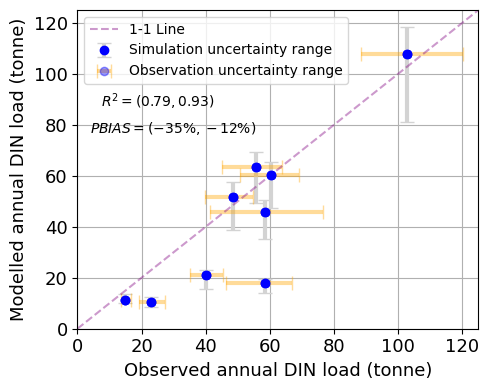

In [14]:
# Create the scatter plot
plt.figure(figsize=(5, 4))
plt.scatter(obs_mid, mod_mid, color='blue')

# Add error bars to both observations and simulations
plt.errorbar(obs_mid, mod_mid, yerr=mod_err, fmt='o', color='blue', 
             ecolor='lightgray', elinewidth=3, capsize=5, label='Simulation uncertainty range')
plt.errorbar(obs_mid, mod_mid, xerr=obs_err, fmt='o', color='blue', 
             ecolor='orange', alpha = 0.4, elinewidth=3, capsize=5, label='Observation uncertainty range')


# Add the 1-1 line
max_value = max(obs_mid.max(), mod_mid.max())  # Get the maximum value for the axis limits
plt.plot([0, 125], [0, 125], color='purple', alpha=0.4, linestyle='--', label='1-1 Line')

# Add labels and title
plt.xlabel('Observed annual DIN load (tonne)', fontsize = lab_fontsize)
plt.ylabel('Modelled annual DIN load (tonne)', fontsize = lab_fontsize)
plt.tick_params(axis='both', labelsize = lab_fontsize)
plt.xlim(0,125)
plt.ylim(0,125)
plt.legend(fontsize = 10)
plt.text(25, 85, r'$R^2 = (%.2f, %.2f)$' % (r2_quantile[0], r2_quantile[1]), fontsize=10, color='black', ha='center', va='bottom')
plt.text(30, 75, r'$PBIAS = (%.0f\%%, %.0f\%%)$' % (pbias_quantile[0], pbias_quantile[1]), fontsize=10, color='black', ha='center', va='bottom')

# Show the plot
plt.grid()
plt.tight_layout()
plt.savefig(f'{fig_dir}ScatterPlotWith Unctn Range.png', format = 'png', dpi = 300)

## 1-2 Time series with uncertainty ranges


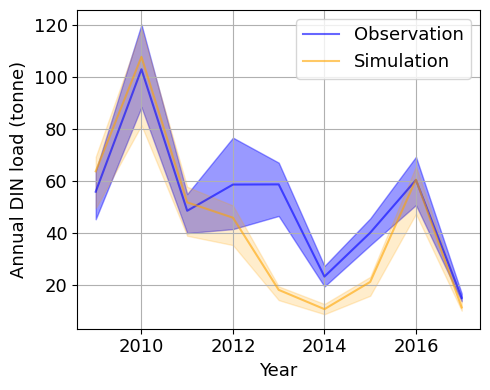

In [15]:
# Plot with uncertainty ranges
plt.figure(figsize=(5, 4))
year_range = np.arange(2009, 2018)
plt.plot(year_range, obs_mid, alpha = 0.6, label='Observation', color='blue')
plt.plot(year_range, mod_mid, alpha = 0.6, label='Simulation', color='orange')

# Add a shaded area for uncertainty (95PPU)
plt.fill_between(year_range, \
                 (obs_mid.values - obs_err.values[0]), \
                 (obs_mid.values + obs_err.values[1]), \
                 color='blue', alpha=0.4)
plt.fill_between(year_range, \
                 (mod_mid.values - mod_err.values[0]), \
                 (mod_mid.values + mod_err.values[1]), \
                 color='orange', alpha=0.2)

# Add labels and title
plt.xlabel('Year', fontsize = lab_fontsize)
plt.ylabel('Annual DIN load (tonne)', fontsize = lab_fontsize)
plt.tick_params(axis='both', labelsize = lab_fontsize)
plt.legend(fontsize = lab_fontsize)

# Show the plot
plt.grid()
plt.tight_layout()
plt.savefig(f'{fig_dir}TimeseriestWithUnctnRange.png', format = 'png', dpi = 300)

## 2-1 Boxplot of parameter posteriors

In [6]:
# Read RELATIVE parameter values -- relative values that are normalized to its prior ranges
par_fn = 'Sandy_Creek.9.par.csv'
par_df = pd.read_csv(data_dir + par_fn, index_col='real_name')
par_melt = pd.melt(par_df, var_name='Parameter Name', value_name='Parameter Value')
# Read parameters prior and names; The column of ShortName will be used as the x-axis index.
default_pars = pd.read_excel('../data/default_starting_params.xlsx')

# Read ABSOLUTE parameter values -- relative values that are normalized to its prior ranges
# Calculate absolute values
abs_par_fn = 'parameter_absolute_value.csv'
if not os.path.exists(data_dir + abs_par_fn):
    abs_par_df = pd.DataFrame(index=par_df.index, columns=par_df.columns)
    for ii in range(par_df.shape[1]):
        abs_par_df.iloc[:, ii] = (par_df.iloc[:, ii] - par_df.iloc[:, ii].min())/ 100 * \
            (default_pars['max'][ii]- default_pars['min'][ii]) + \
            default_pars['min'][ii]
    abs_par_df.to_csv(data_dir + abs_par_fn)
abs_par_df = pd.read_csv(data_dir + abs_par_fn, index_col='real_name')
abs_par_melt = pd.melt(abs_par_df, var_name='Parameter Name', value_name='Parameter Value')

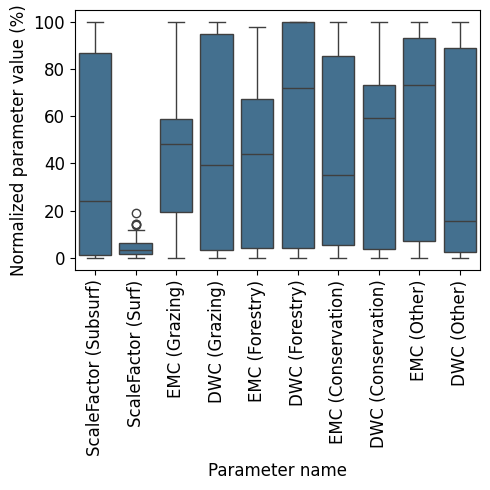

In [7]:
# Boxplot
plt.figure(figsize=(5, 5))
ax = sns.boxplot(data=par_melt, x = 'Parameter Name', y = 'Parameter Value', saturation=0.5)
plt.ylabel('Normalized parameter value (%)', fontsize = 12)
plt.xlabel('Parameter name', fontsize = 12)
plt.xticks(ticks=np.arange(default_pars.shape[0]), labels=default_pars['ShortName'], rotation = 90);
plt.tick_params(axis='both', labelsize = 12)
# Show the plot
plt.tight_layout()
# plt.savefig(f'{fig_dir}BoxPlotParameterUncertainty_Lab.png', format = 'png', dpi = 300)

## 2-2 Pairwise Plot between parameters: SDR and gEMC

In [10]:
new_xlabels

['ScaleFactor (Surf)', 'EMC (Grazing)', 'ScaleFactor (Surf)', 'EMC (Grazing)']

<Figure size 500x800 with 0 Axes>

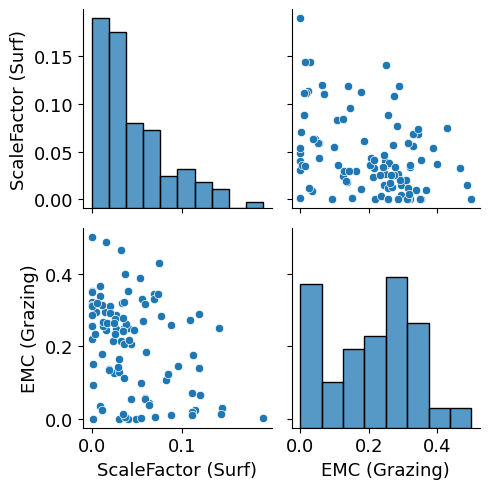

In [15]:
fig = plt.figure(figsize=(5, 8))
pairplot = sns.pairplot(abs_par_df.loc[:, ['scale_din','gemc']])
# Customize x-axis labels for each plot
new_xlabels = [default_pars['ShortName'][1], default_pars['ShortName'][2],\
               default_pars['ShortName'][1], default_pars['ShortName'][2]]
for i, ax in enumerate(pairplot.axes.flatten()):
    # Change x-axis label for each subplot
    ax.set_xlabel(new_xlabels[i], fontsize = lab_fontsize)
    ax.tick_params(labelsize = lab_fontsize)
    # ax.add_patch(Rectangle((0, 0), 1, 1, fill=False, color='black', lw=2, transform=ax.transAxes))
    if i == 0:
        ax.set_ylabel(new_xlabels[i], fontsize = lab_fontsize)
    elif i == 2:
        ax.set_ylabel(new_xlabels[1], fontsize = lab_fontsize)

# Show the plot
plt.tight_layout()
plt.savefig(f'{fig_dir}PairPlotParameters.png', format = 'png', dpi = 300)

In [28]:
# Annual scale L-Q plot; seasonal scale average concentration?
# Function for convert data to 
def annual_data(df, flow_col):
    """
    df: dataframe containing datetime, daily flow and load.
    """
    # Sample DataFrame creation (replace this with your actual DataFrame)
    # Define water year: if the month is July (7) or later, it belongs to the next calendar year
    df['water_year'] = df['date'].apply(lambda x: x.year - 1 if x.month < 7 else x.year)
    # Normalize the data within each water year
    annual_flow = df.groupby('water_year')[flow_col].sum()
    return annual_flow

In [29]:
# Calculate modelled annual flow.
## Read model simulations
# The mdoelled flow does not change because no runoff parameters being inferenced.
dir = '../output/DailyData_run_till_2017_20241125/'
mod_fn_list = os.listdir(dir)
mod_fn_list = [fn for fn in mod_fn_list if '_' in fn ]
flow_col = 'Q (m3/s)'
# Calculate the cumulative normalized value for flow and load.
ind_row = 0
for fn in mod_fn_list[0:1]:
    mod_flow_load = pd.read_csv(dir + fn)
    mod_flow_load.rename(columns={'Unnamed: 0': 'date'}, inplace=True)
    mod_flow_load['date'] = pd.to_datetime(mod_flow_load['date'], format='%Y-%m-%d')
    mod_annual_flow = annual_data(mod_flow_load, flow_col) * 86400 / 343.79 /1e6 * 1000
    ind_row += 1
# Calculate obseved annual flow.
obs_flow_load = pd.read_csv('../data/obs_low_interp_flow.csv')
obs_flow_load['date'] = pd.to_datetime(obs_flow_load['date'], format='%d/%m/%Y') 
obs_annnual_flow = annual_data(obs_flow_load, flow_col) * 86400 / 343.79 /1e6 * 1000

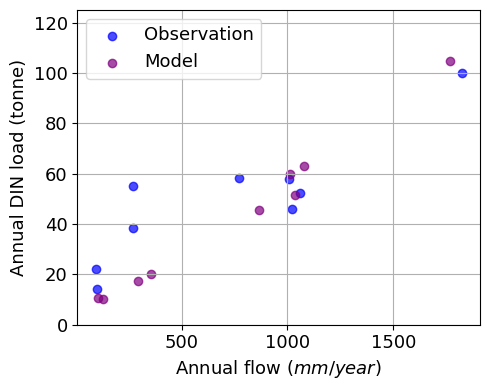

In [30]:
# Create the scatter plot
plt.figure(figsize=(5, 4))
plt.scatter(obs_annnual_flow, obs_base, color='blue', alpha=0.7, label='Observation')
plt.scatter(mod_annual_flow[0:-5], mod_mid, color='purple', alpha=0.7, label='Model')

# Add labels and title
plt.xlabel('Annual flow'+r' $(mm/year)$', fontsize = lab_fontsize)
plt.ylabel('Annual DIN load (tonne)', fontsize = lab_fontsize)
plt.tick_params(axis='both', labelsize = lab_fontsize)
plt.legend(fontsize = lab_fontsize)
plt.ylim(0, 125)

# Show the plot
plt.grid()
plt.tight_layout()
plt.savefig(f'{fig_dir}ScatterPlotFlowLoad.png', format = 'png', dpi = 300)